
# 🚀 Introducción al A/B Testing

Objetivo: En este notebook exploraremos cómo formular y verificar hipótesis de negocio, realizar pruebas A/B, y priorizar experimentos para optimizar decisiones basadas en datos. Estructura del notebook:

- Fundamentos teóricos
- Ejemplo de prueba A/B con explicación detallada
- Priorizar hipótesis usando WSJF, ICE y RICE
- Teoría complementaria sobre pruebas y diseño experimental




# 📊 Fundamentos Estadísticos

Un test A/B compara dos grupos (A y B) para ver si existe **una diferencia estadísticamente significativa**.

### Hipótesis
- $H_0$: No hay diferencia entre A y B (la variante no mejora nada).
- $H_1$: Sí hay diferencia (la variante mejora).

Usamos un **nivel de significancia** (α = 0.05 generalmente).




# 📂 Cargar y explorar los datos


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Activamos el estilo de fondo oscuro
plt.style.use("dark_background")

# Dataset para prueba A/B
data_ab = pd.DataFrame({
    'date': pd.date_range(start='2025-01-01', periods=100),
    'group': np.random.choice(['A', 'B'], size=100),
    'visitors': np.random.poisson(100, size=100),
    'orders': np.random.binomial(n=np.random.poisson(100, size=100), p=0.1)
})

# Dataset para WSJF
hypothesis_wsjf = pd.DataFrame({
    'hypothesis': ['Hip1', 'Hip2', 'Hip3', 'Hip4'],
    'user_business_value': [8, 5, 3, 9],
    'time_criticality': [7, 6, 4, 8],
    'risk_reduction_opportunity_enablement': [5, 7, 6, 4],
    'job_size': [3, 2, 5, 4]
})

# Dataset para ICE
hypothesis_ice = pd.DataFrame({
    'hypothesis': ['Hip1', 'Hip2', 'Hip3', 'Hip4'],
    'impact': [9, 6, 4, 8],
    'confidence': [8, 9, 5, 7],
    'efforts': [4, 3, 5, 6]
})

# Dataset para RICE
hypothesis_rice = pd.DataFrame({
    'hypothesis': ['Hip1', 'Hip2', 'Hip3', 'Hip4'],
    'reach': [1000, 800, 600, 1200],
    'impact': [9, 6, 4, 8],
    'confidence': [8, 9, 5, 7],
    'efforts': [4, 3, 5, 6]
})



# 🔍 A/B Testing
Objetivo: Medir la diferencia en la tasa de conversión entre el grupo A (control) y el grupo B (variante). 

Pasos:
1. Resumir datos por grupo.
2. Calcular la métrica clave: órdenes por visitante.
3. Interpretar si hay diferencias relevantes.


In [16]:
# Paso 1: Mostrar primeras filas del dataset
data_ab.head(5)

,date,group,visitors,orders
0,2025-01-01,A,96,10
1,2025-01-02,A,106,13
2,2025-01-03,B,94,7
3,2025-01-04,A,116,11
4,2025-01-05,B,102,13


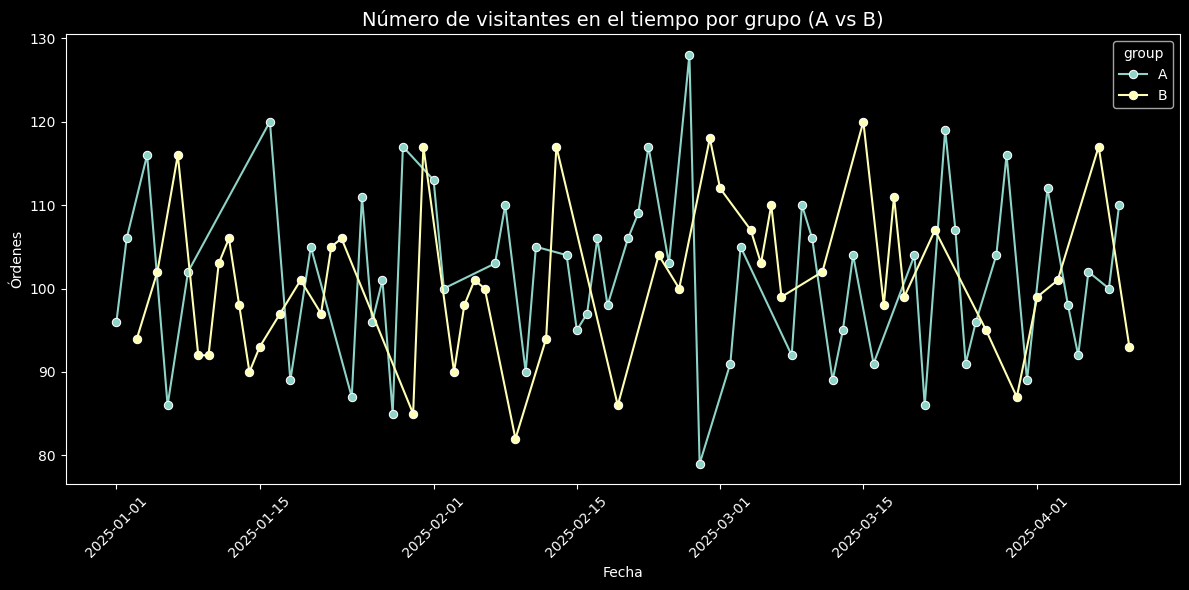

In [17]:
# Gráfico con seaborn: número de visitantes en el tiempo por grupo
plt.figure(figsize=(12,6))
sns.lineplot(data=data_ab, x='date', y='visitors', hue='group', marker='o')
plt.title("Número de visitantes en el tiempo por grupo (A vs B)", fontsize=14)
plt.xlabel("Fecha")
plt.ylabel("Órdenes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

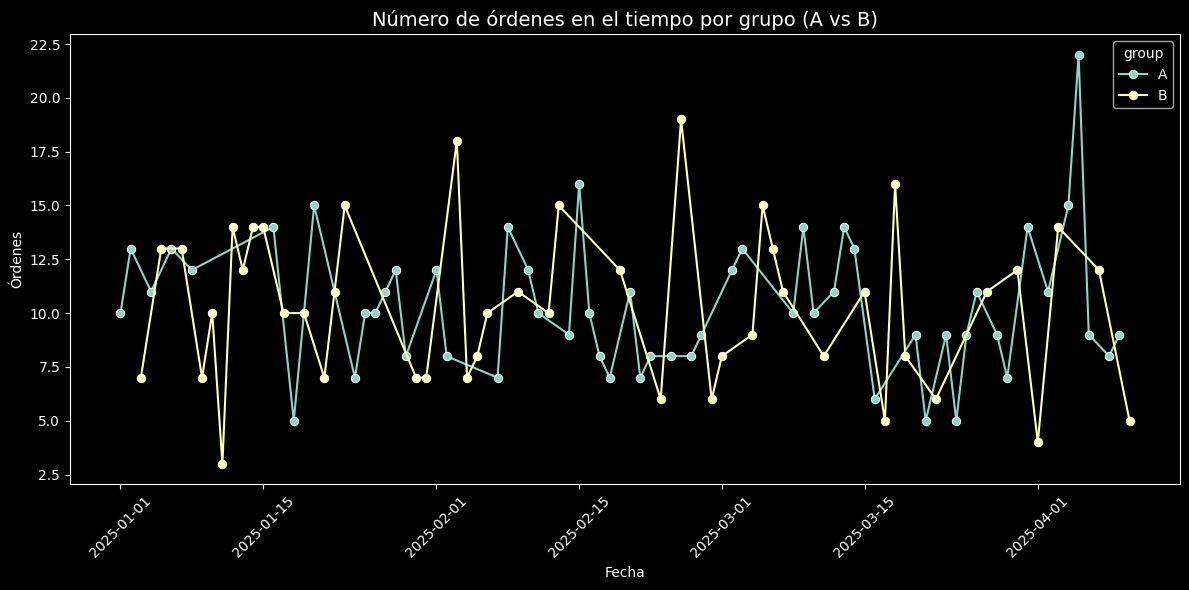

In [18]:
# Gráfico con seaborn: número de órdenes en el tiempo por grupo
plt.figure(figsize=(12,6))
sns.lineplot(data=data_ab, x='date', y='orders', hue='group', marker='o')
plt.title("Número de órdenes en el tiempo por grupo (A vs B)", fontsize=14)
plt.xlabel("Fecha")
plt.ylabel("Órdenes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
data_ab.groupby('group').agg({'visitors': 'sum', 'orders': 'sum'}).reset_index()

,group,visitors,orders
0,A,5589,570
1,B,4544,464


In [20]:
# Paso 2: Agrupar y sumar visitantes y órdenes por grupo
table_ab = (
    data_ab.drop(columns=['date'])
           .groupby('group', as_index=False)
           .agg({'visitors': 'sum', 'orders': 'sum'})
)

table_ab.head()

,group,visitors,orders
0,A,5589,570
1,B,4544,464


Una gráfica ayuda a ver rápidamente si parece haber una diferencia.  
¡Pero cuidado! Lo visual no siempre es estadísticamente significativo 😉


In [21]:
# Paso 3: Calcular tasa de conversión y mostrar resultados
table_ab['orders_to_visitors_ratio'] = table_ab['orders'] / table_ab['visitors']
print(table_ab)

  group  visitors  orders  orders_to_visitors_ratio
0     A      5589     570                  0.101986
1     B      4544     464                  0.102113



# 🧪 Frameworks de priorización de hipótesis

¿Cómo se por donde empezar?

**Recordemos que una vez yo ya tengo mi hipotesis, para probar estadísticamente si son validas o no puedo hacer lo siguiente:**

Aplicamos pruebas como **t-test** o **chi-cuadrado** (dependiendo del tipo de variable) y la idea es calcular un **p-value**:

- Si $p < α$: Rechazamos $H_0$ → Hay diferencia significativa.
- Si $p ≥ α$: No hay suficiente evidencia → No podemos rechazar $H_0$.


In [27]:
# Separar órdenes por grupo
orders_A = data_ab.loc[data_ab['group'] == 'A', 'orders']
orders_B = data_ab.loc[data_ab['group'] == 'B', 'orders']

# Test de Levene para igualdad de varianzas
levene_stat, levene_p = stats.levene(orders_A, orders_B)
print(f"Levene test p-value: {levene_p:.4f}")

# Decisión sobre varianzas
if levene_p < 0.05:
    print("❌ Varianzas distintas → usamos t-test con equal_var=False")
    equal_var = False
else:
    print("✅ Varianzas iguales → usamos t-test con equal_var=True")
    equal_var = True

# Prueba t de Student según resultado de Levene
t_stat, p_value = stats.ttest_ind(orders_A, orders_B)
print(f"\nt-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

# Interpretación
alpha = 0.05
if p_value < alpha:
    print("Rechazamos H0: existe diferencia significativa entre A y B ✅")
else:
    print("No podemos rechazar H0: no hay diferencia significativa ❌")


Levene test p-value: 0.1149
✅ Varianzas iguales → usamos t-test con equal_var=True

t-statistic: 0.0761
p-value: 0.9395
No podemos rechazar H0: no hay diferencia significativa ❌


### 3.1 WSJF (Weighted Shortest Job First)
Fórmula: 
$$
WSJF = \frac{\text{ValorNegocio} + \text{Urgencia} + \text{Riesgo}}{\text{TamañoTrabajo}}
$$
Donde:
- **ValorNegocio:** Beneficio esperado.
- **Urgencia:** Críticas del mercado.
- **Riesgo:** Oportunidad de reducción de riesgo.
- **TamañoTrabajo:** Esfuerzo estimado.


In [23]:
hypothesis_wsjf.head()

,hypothesis,user_business_value,time_criticality,risk_reduction_opportunity_enablement,job_size
0,Hip1,8,7,5,3
1,Hip2,5,6,7,2
2,Hip3,3,4,6,5
3,Hip4,9,8,4,4


In [24]:
# Cálculo de WSJF y ordenamiento
hypothesis_wsjf['WSJF'] = (
    hypothesis_wsjf['user_business_value'] + 
    hypothesis_wsjf['time_criticality'] + 
    hypothesis_wsjf['risk_reduction_opportunity_enablement']
) / hypothesis_wsjf['job_size']

print(hypothesis_wsjf[['hypothesis', 'WSJF']].sort_values(by='WSJF', ascending=False))


  hypothesis      WSJF
1       Hip2  9.000000
0       Hip1  6.666667
3       Hip4  5.250000
2       Hip3  2.600000


### 3.2 ICE (Impact, Confidence, Ease)
Fórmula: 
$$
ICE = \frac{Impact \times Confianza}{Esfuerzo}
$$

Donde:
- **Impacto:** Crecimiento esperado.
- **Confianza:** Nivel de certeza en la estimación.
- **Esfuerzo:** Recursos necesarios.

In [25]:
# Cálculo de ICE y ordenamiento
hypothesis_ice['ICE'] = (
    hypothesis_ice['impact'] * hypothesis_ice['confidence']
) / hypothesis_ice['efforts']
print(hypothesis_ice[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))


  hypothesis        ICE
0       Hip1  18.000000
1       Hip2  18.000000
3       Hip4   9.333333
2       Hip3   4.000000


### 3.3 RICE (Reach, Impact, Confidence, Effort)
Fórmula: 

$$
RICE = \frac{Reach \times Impact \times Confianza}{Esfuerzo}
$$

Donde:
- **Reach:** Usuarios afectados.
- **Impact:** Mejora por usuario.
- **Confianza:** Precisión de las estimaciones.
- **Esfuerzo:** Recursos necesarios.

In [26]:
# Cálculo de RICE y ordenamiento
hypothesis_rice['RICE'] = (
    hypothesis_rice['reach'] * hypothesis_rice['impact'] * hypothesis_rice['confidence']
) / hypothesis_rice['efforts']
print(hypothesis_rice[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))


  hypothesis     RICE
0       Hip1  18000.0
1       Hip2  14400.0
3       Hip4  11200.0
2       Hip3   2400.0



# 🤔 Interpretación de Resultados

El **p-value** nos dice si la diferencia observada probablemente sea **real** o solo un producto del azar.

👉 Aquí es donde traducimos los números en **decisiones de negocio**.



## ⚠️ Problemas comunes en A/B Testing

- Tamaño de muestra insuficiente (¡puedes sacar conclusiones erróneas!).
- Múltiples tests a la vez → aumenta la probabilidad de falsos positivos.
- Sesgos en la asignación de grupos.

💡 Recuerda: **Un mal diseño arruina cualquier análisis**.



## Cierre y Conclusiones

- El A/B Testing combina **estadística + negocio**.
- No basta con mirar números → hay que interpretar en contexto.
- La práctica continua mejora tu criterio como analista.

🙋‍♀️ Preguntas finales → ¡Abrimos discusión!
